In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
cd "drive/MyDrive/Doutorado/Disciplinas/[2022.2] [PUC-Rio] Visão Computacional - Professor: Marcelo Gattass/Trabalhos/Trabalho Final/Code/What does a CNN see?/"

/content/drive/MyDrive/Doutorado/Disciplinas/[2022.2] [PUC-Rio] Visão Computacional - Professor: Marcelo Gattass/Trabalhos/Trabalho Final/Code/What does a CNN see?


In [3]:
!pwd

/content/drive/MyDrive/Doutorado/Disciplinas/[2022.2] [PUC-Rio] Visão Computacional - Professor: Marcelo Gattass/Trabalhos/Trabalho Final/Code/What does a CNN see?


In [4]:
data_folder = './data/'

In [5]:
import os
import cv2
import glob
import h5py
import shutil
import imgaug as aug
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import imgaug.augmenters as iaa
from os import listdir, makedirs, getcwd, remove
from os.path import isfile, join, abspath, exists, isdir, expanduser
from pathlib import Path
from skimage.io import imread
from skimage.transform import resize
from keras.models import Sequential, Model, load_model
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, InputLayer, Flatten
from keras.optimizers import Adam, SGD, RMSprop
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
from keras import backend as K
import tensorflow as tf
tf.compat.v1.disable_eager_execution() # daniel


color = sns.color_palette()
%matplotlib inline
%config InlineBackend.figure_format="svg"

# Daniel
from tensorflow.keras import datasets, layers, models

In [6]:
# Set the seed for hash based operations in python
os.environ['PYTHONHASHSEED'] = '0'

seed=1234

# Set the numpy seed
np.random.seed(seed)

# Set the random seed in tensorflow at graph level
# tf.set_random_seed(seed) # obsolete
tf.random.set_seed(seed)

# Make the augmentation sequence deterministic
aug.seed(seed)

In [7]:
# As usual, define some paths first to make life simpler
training_data = Path(data_folder + '/training/') 
validation_data = Path(data_folder + '/validation/') 
labels_path = Path(data_folder + '/monkey_labels.txt')

In [8]:
labels_info = []

# Read the file
lines = labels_path.read_text().strip().splitlines()[1:]
for line in lines:
    line = line.split(',')
    line = [x.strip(' \n\t\r') for x in line]
    line[3], line[4] = int(line[3]), int(line[4])
    line = tuple(line)
    labels_info.append(line)
    
# Convert the data into a pandas dataframe
labels_info = pd.DataFrame(labels_info, columns=['Label', 'Latin Name', 'Common Name', 
                                                 'Train Images', 'Validation Images'], index=None)
# Sneak peek 
labels_info.head(10)

,Label,Latin Name,Common Name,Train Images,Validation Images
0,n0,alouatta_palliata,mantled_howler,131,26
1,n1,erythrocebus_patas,patas_monkey,139,28
2,n2,cacajao_calvus,bald_uakari,137,27
3,n3,macaca_fuscata,japanese_macaque,152,30
4,n4,cebuella_pygmea,pygmy_marmoset,131,26
5,n5,cebus_capucinus,white_headed_capuchin,141,28
6,n6,mico_argentatus,silvery_marmoset,132,26
7,n7,saimiri_sciureus,common_squirrel_monkey,142,28
8,n8,aotus_nigriceps,black_headed_night_monkey,133,27
9,n9,trachypithecus_johnii,nilgiri_langur,132,26


In [9]:
# Create a dictionary to map the labels to integers
labels_dict= {'n0':0, 'n1':1, 'n2':2, 'n3':3, 'n4':4, 'n5':5, 'n6':6, 'n7':7, 'n8':8, 'n9':9}

# map labels to common names
names_dict = dict(zip(labels_dict.values(), labels_info["Common Name"]))
print(names_dict)

{0: 'mantled_howler', 1: 'patas_monkey', 2: 'bald_uakari', 3: 'japanese_macaque', 4: 'pygmy_marmoset', 5: 'white_headed_capuchin', 6: 'silvery_marmoset', 7: 'common_squirrel_monkey', 8: 'black_headed_night_monkey', 9: 'nilgiri_langur'}


In [10]:
# Creating a dataframe for the training dataset
train_df = []
for folder in os.listdir(training_data):
    # Define the path to the images
    imgs_path = training_data / folder
    
    # Get the list of all the images stored in that directory
    imgs = sorted(imgs_path.glob('*.jpg'))
    
    # Store each image path and corresponding label 
    for img_name in imgs:
        train_df.append((str(img_name), labels_dict[folder]))


train_df = pd.DataFrame(train_df, columns=['image', 'label'], index=None)
# shuffle the dataset 
train_df = train_df.sample(frac=1.).reset_index(drop=True)

####################################################################################################

# Creating dataframe for validation data in a similar fashion
valid_df = []
for folder in os.listdir(validation_data):
    imgs_path = validation_data / folder
    imgs = sorted(imgs_path.glob('*.jpg'))
    for img_name in imgs:
        valid_df.append((str(img_name), labels_dict[folder]))

        
valid_df = pd.DataFrame(valid_df, columns=['image', 'label'], index=None)
# shuffle the dataset 
valid_df = valid_df.sample(frac=1.).reset_index(drop=True)

####################################################################################################

# How many samples do we have in our training and validation data?
print("Number of traininng samples: ", len(train_df))
print("Number of validation samples: ", len(valid_df))

# sneak peek of the training and validation dataframes
print("\n",train_df.head(), "\n")
print("=================================================================\n")
print("\n", valid_df.head())

Number of traininng samples:  1096
Number of validation samples:  272

                         image  label
0  data/training/n2/n2117.jpg      2
1  data/training/n7/n7028.jpg      7
2  data/training/n0/n0155.jpg      0
3  data/training/n7/n7064.jpg      7
4  data/training/n2/n2133.jpg      2 



                           image  label
0   data/validation/n7/n718.jpg      7
1  data/validation/n6/n6013.jpg      6
2  data/validation/n7/n7012.jpg      7
3   data/validation/n5/n512.jpg      5
4   data/validation/n5/n509.jpg      5


In [11]:
# some constants(not truly though!) 

# dimensions to consider for the images
img_rows, img_cols, img_channels = 224,224,3

# batch size for training  
batch_size=8

# total number of classes in the dataset
nb_classes=10

In [12]:
# Augmentation sequence 
seq = iaa.OneOf([
    iaa.Fliplr(), # horizontal flips
    iaa.Affine(rotate=20), # roatation
    iaa.Multiply((1.2, 1.5))]) #random brightness

In [13]:
def data_generator(data, batch_size, is_validation_data=False):
    # Get total number of samples in the data
    n = len(data)
    nb_batches = int(np.ceil(n/batch_size))

    # Get a numpy array of all the indices of the input data
    indices = np.arange(n)
    
    # Define two numpy arrays for containing batch data and labels
    batch_data = np.zeros((batch_size, img_rows, img_cols, img_channels), dtype=np.float32)
    batch_labels = np.zeros((batch_size, nb_classes), dtype=np.float32)
    
    while True:
        if not is_validation_data:
            # shuffle indices for the training data
            np.random.shuffle(indices)
            
        for i in range(nb_batches):
            # get the next batch 
            next_batch_indices = indices[i*batch_size:(i+1)*batch_size]
            
            # process the next batch
            for j, idx in enumerate(next_batch_indices):
                img = cv2.imread(data.iloc[idx]["image"])
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                label = data.iloc[idx]["label"]
                
                if not is_validation_data:
                    img = seq.augment_image(img)
                
                img = cv2.resize(img, (img_rows, img_cols)).astype(np.float32)
                batch_data[j] = img
                batch_labels[j] = to_categorical(label,num_classes=nb_classes)
            
            batch_data = preprocess_input(batch_data)
            yield batch_data, batch_labels

In [14]:
#training data generator 
train_data_gen = data_generator(train_df, batch_size)

# validation data generator 
valid_data_gen = data_generator(valid_df, batch_size, is_validation_data=True)

In [15]:
# https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D
# tf.keras.layers.Conv2D( filters, kernel_size, ...)

model = models.Sequential([
    layers.InputLayer( input_shape=(224, 224, 3) )
])

model.add( layers.Conv2D(64, (11, 11), 
                        padding='same',
                        activation='relu') )
model.add( layers.MaxPooling2D((2, 2)) )

model.add( layers.Conv2D(128, (11, 11), 
                        padding='same',
                        activation='relu') )
model.add( layers.MaxPooling2D((2, 2)) )

model.add( layers.Conv2D(256, (11, 11), 
                        padding='same',
                        activation='relu') )
model.add( layers.MaxPooling2D((2, 2)) )

model.add( layers.Conv2D(512, (11, 11), 
                        padding='same',
                        activation='relu') )
model.add( layers.MaxPooling2D((2, 2)) )

model.add( layers.Conv2D(512, (11, 11), 
                        padding='same',
                        activation='relu') )
model.add( layers.Conv2D(512, (11, 11), 
                        padding='same',
                        activation='relu') )
model.add( layers.MaxPooling2D((2, 2)) )

model.add( layers.Flatten() )
model.add( layers.Dense(4096, activation='relu') )
model.add( layers.Dense(4096, activation='relu') )
model.add( layers.Dropout(0.2) )
model.add( layers.Dense(10, activation='softmax') )

# To correct some bug on input
model = Model(model.input, model.output)

optimizer = RMSprop(0.001)
model.compile(optimizer = optimizer, 
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 64)      23296     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 64)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 128)     991360    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 128)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 256)       396518

In [16]:
early_stopping = EarlyStopping(patience=20, restore_best_weights=True)

model_checkpoint = ModelCheckpoint(filepath="model1", save_best_only=True)

num_train_steps = int(np.ceil(len(train_df)/batch_size))
num_valid_steps = int(np.ceil(len(valid_df)/batch_size))

In [17]:
epochs=100
# epochs=5 # daniel

In [18]:
%%time

# train the model 
history1 = model.fit(train_data_gen, 
                              epochs = epochs, 
                              steps_per_epoch = num_train_steps, 
                              validation_data = valid_data_gen, 
                              validation_steps = num_valid_steps,
                              callbacks = [early_stopping, model_checkpoint])

Epoch 1/100
137/137 [==============================] - ETA: 0s - batch: 68.0000 - size: 8.0000 - loss: 267011271.3737 - accuracy: 0.1058

/usr/local/lib/python3.8/dist-packages/keras/engine/training_v1.py:2045: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


137/137 [==============================] - 50s 322ms/step - batch: 68.0000 - size: 8.0000 - loss: 267011271.3737 - accuracy: 0.1058 - val_loss: 5.6905 - val_accuracy: 0.1176
Epoch 2/100
137/137 [==============================] - ETA: 0s - batch: 68.0000 - size: 8.0000 - loss: 11.4132 - accuracy: 0.1405

137/137 [==============================] - 46s 339ms/step - batch: 68.0000 - size: 8.0000 - loss: 11.4132 - accuracy: 0.1405 - val_loss: 2.3013 - val_accuracy: 0.1544
Epoch 3/100
137/137 [==============================] - 38s 281ms/step - batch: 68.0000 - size: 8.0000 - loss: 94.7082 - accuracy: 0.1049 - val_loss: 2.3021 - val_accuracy: 0.0993
Epoch 4/100
137/137 [==============================] - 37s 271ms/step - batch: 68.0000 - size: 8.0000 - loss: 157.7117 - accuracy: 0.1122 - val_loss: 2.3019 - val_accuracy: 0.1029
Epoch 5/100
137/137 [==============================] - 38s 279ms/step - batch: 68.0000 - size: 8.0000 - loss: 935.8163 - accuracy: 0.1058 - val_loss: 2.3016 - val_accuracy: 0.1213
Epoch 6/100
137/137 [==============================] - 39s 285ms/step - batch: 68.0000 - size: 8.0000 - loss: 304.4731 - accuracy: 0.1004 - val_loss: 2.6552 - val_accuracy: 0.1176
Epoch 7/100
137/137 [==============================] - ETA: 0s - batch: 68.0000 - size: 8.0000 - loss: 8.2983 - ac

137/137 [==============================] - 46s 341ms/step - batch: 68.0000 - size: 8.0000 - loss: 8.2983 - accuracy: 0.1086 - val_loss: 2.2996 - val_accuracy: 0.1066
Epoch 8/100
137/137 [==============================] - 41s 302ms/step - batch: 68.0000 - size: 8.0000 - loss: 427.2030 - accuracy: 0.1259 - val_loss: 2.3145 - val_accuracy: 0.1397
Epoch 9/100
137/137 [==============================] - 41s 299ms/step - batch: 68.0000 - size: 8.0000 - loss: 2.6490 - accuracy: 0.1223 - val_loss: 2.3021 - val_accuracy: 0.1103
Epoch 10/100
137/137 [==============================] - 40s 293ms/step - batch: 68.0000 - size: 8.0000 - loss: 46.8082 - accuracy: 0.1150 - val_loss: 2.3049 - val_accuracy: 0.0993
Epoch 11/100
137/137 [==============================] - 39s 286ms/step - batch: 68.0000 - size: 8.0000 - loss: 9.5431 - accuracy: 0.1223 - val_loss: 3.0572 - val_accuracy: 0.0993
Epoch 12/100
137/137 [==============================] - 40s 291ms/step - batch: 68.0000 - size: 8.0000 - loss: 8.2210

137/137 [==============================] - 48s 356ms/step - batch: 68.0000 - size: 8.0000 - loss: 2.5384 - accuracy: 0.1113 - val_loss: 2.2861 - val_accuracy: 0.1029
Epoch 26/100
137/137 [==============================] - 42s 311ms/step - batch: 68.0000 - size: 8.0000 - loss: 33.8057 - accuracy: 0.1369 - val_loss: 2.3177 - val_accuracy: 0.1250
Epoch 27/100
137/137 [==============================] - 41s 304ms/step - batch: 68.0000 - size: 8.0000 - loss: 2.6132 - accuracy: 0.1350 - val_loss: 2.3080 - val_accuracy: 0.0956
Epoch 28/100
137/137 [==============================] - 42s 308ms/step - batch: 68.0000 - size: 8.0000 - loss: 10.2055 - accuracy: 0.1031 - val_loss: 2.3131 - val_accuracy: 0.1103
Epoch 29/100
137/137 [==============================] - 42s 305ms/step - batch: 68.0000 - size: 8.0000 - loss: 2.3912 - accuracy: 0.1277 - val_loss: 2.3021 - val_accuracy: 0.1103
Epoch 30/100
137/137 [==============================] - 42s 308ms/step - batch: 68.0000 - size: 8.0000 - loss: 10.91

In [19]:
history1.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

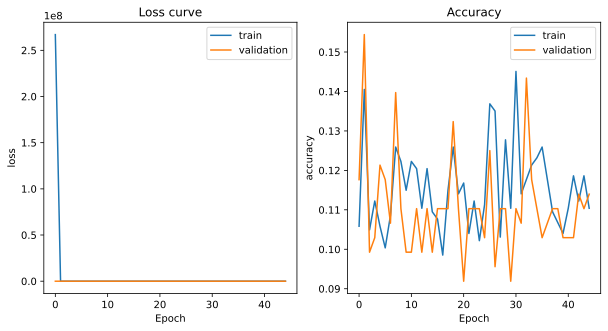

In [20]:
# let's plot the loss and accuracy 

# get the training and validation accuracy from the history object
train_acc = history1.history['accuracy']
valid_acc = history1.history['val_accuracy']

# get the loss
train_loss = history1.history['loss']
valid_loss = history1.history['val_loss']

# get the number of entries
xvalues = np.arange(len(train_acc))

# visualize
f,ax = plt.subplots(1,2, figsize=(10,5))
ax[0].plot(xvalues, train_loss)
ax[0].plot(xvalues, valid_loss)
ax[0].set_title("Loss curve")
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("loss")
ax[0].legend(['train', 'validation'])

ax[1].plot(xvalues, train_acc)
ax[1].plot(xvalues, valid_acc)
ax[1].set_title("Accuracy")
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("accuracy")
ax[1].legend(['train', 'validation'])

plt.show()

In [21]:
# What is the final loss and accuracy on our validation data?
valid_loss, valid_acc = model.evaluate_generator(valid_data_gen, steps=num_valid_steps)
print(f"Final validation accuracy: {valid_acc*100:.2f}%")

<ipython-input-21-e428c4fc796b>:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  valid_loss, valid_acc = model.evaluate_generator(valid_data_gen, steps=num_valid_steps)


Final validation accuracy: 10.29%


In [22]:
outputs = [layer.output for layer in model.layers[1:18]]

vis_model = Model(model.input, outputs)

for layer in vis_model.layers:
  layer.trainable = False

vis_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 64)      23296     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 64)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 128)     991360    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 128)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 256)       3965

In [23]:
# store the layer names we are interested in
layer_names = []
for layer in outputs:
    layer_names.append(layer.name.split("/")[0])

    
print("Layers going to be used for visualization: ")
print(layer_names)

Layers going to be used for visualization: 
['conv2d', 'max_pooling2d', 'conv2d_1', 'max_pooling2d_1', 'conv2d_2', 'max_pooling2d_2', 'conv2d_3', 'max_pooling2d_3', 'conv2d_4', 'conv2d_5', 'max_pooling2d_4', 'flatten', 'dense', 'dense_1', 'dropout', 'dense_2']


In [24]:
print( f'layer_names [before]: {layer_names}' )

layer_names_temp = layer_names
layer_names = list()
for layer in layer_names_temp:

  if 'conv' in layer:
    # print(layer)
    layer_names.append( layer )

print( '=========================================' )
print( f'layer_names [after]: {layer_names}' )

layer_names [before]: ['conv2d', 'max_pooling2d', 'conv2d_1', 'max_pooling2d_1', 'conv2d_2', 'max_pooling2d_2', 'conv2d_3', 'max_pooling2d_3', 'conv2d_4', 'conv2d_5', 'max_pooling2d_4', 'flatten', 'dense', 'dense_1', 'dropout', 'dense_2']
layer_names [after]: ['conv2d', 'conv2d_1', 'conv2d_2', 'conv2d_3', 'conv2d_4', 'conv2d_5']


In [25]:
def get_CAM(processed_image, predicted_label):
    """
    This function is used to generate a heatmap for a sample image prediction.
    
    Args:
        processed_image: any sample image that has been pre-processed using the 
                       `preprocess_input()`method of a keras model
        predicted_label: label that has been predicted by the network for this image
    
    Returns:
        heatmap: heatmap generated over the last convolution layer output 
    """
    # we want the activations for the predicted label
    predicted_output = model.output[:, predicted_label]
    
    # choose the last conv layer in your model
    # last_conv_layer = model.get_layer('block5_conv3')
    last_conv_layer = model.get_layer(layer_names[-1])
    
    # get the gradients wrt to the last conv layer
    grads = K.gradients(predicted_output, last_conv_layer.output)[0]
    
    # take mean gradient per feature map
    grads = K.mean(grads, axis=(0,1,2)) # GAP - Global Average Pooling
    
    # Define a function that generates the values for the output and gradients
    evaluation_function = K.function([model.input], [grads, last_conv_layer.output[0]])
    
    # get the values
    grads_values, conv_ouput_values = evaluation_function([processed_image])
    
    # CAM - Class Activation Map
    # iterate over each feature map in yout conv output and multiply
    # the gradient values with the conv output values. This gives an 
    # indication of "how important a feature is"
    # for i in range(512): # we have 512 features in our last conv layer
    for i in range(conv_ouput_values.shape[2]): # daniel
        conv_ouput_values[:,:,i] *= grads_values[i]
    
    # create a heatmap
    heatmap = np.mean(conv_ouput_values, axis=-1)
    
    # remove negative values
    heatmap = np.maximum(heatmap, 0)
    
    # normalize
    heatmap /= heatmap.max()
    
    return heatmap

In [26]:
idx = 0

/usr/local/lib/python3.8/dist-packages/keras/engine/training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


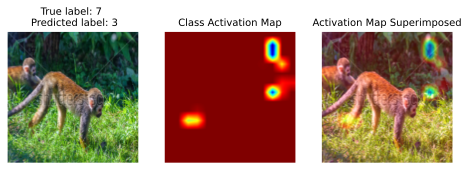

In [27]:
# select the sample and read the corresponding image and label
sample_image = cv2.imread(valid_df.iloc[idx]['image'])
sample_image = cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB)
sample_image = cv2.resize(sample_image, (img_rows, img_cols))
sample_label = valid_df.iloc[idx]["label"]

# pre-process the image
sample_image_processed = np.expand_dims(sample_image, axis=0)
sample_image_processed = preprocess_input(sample_image_processed)

# get the label predicted by our original model
pred_label = np.argmax(model.predict(sample_image_processed), axis=-1)[0]

# get the heatmap for class activation map(CAM)
heatmap = get_CAM(sample_image_processed, pred_label)
heatmap = cv2.resize(heatmap, (sample_image.shape[0], sample_image.shape[1]))
heatmap = heatmap *255
heatmap = np.clip(heatmap, 0, 255).astype(np.uint8)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
super_imposed_image = heatmap * 0.5 + sample_image
super_imposed_image = np.clip(super_imposed_image, 0,255).astype(np.uint8)

# Ploting
fontsize = 10
fig, axes = plt.subplots( 1, 3, figsize=( 8, 8 ) )
axes[0].set_title( f'True label: {sample_label} \n Predicted label: {pred_label}',
                  fontsize = fontsize )
axes[0].axis('off')
axes[0].imshow( sample_image )

axes[1].set_title( f'Class Activation Map',
                  fontsize = fontsize )
axes[1].axis('off')
axes[1].imshow( heatmap )

axes[2].set_title( f'Activation Map Superimposed',
                  fontsize = fontsize )
axes[2].axis('off')
axes[2].imshow( super_imposed_image )
plt.show()

# # Plot just CAM of the layer
# plt.figure( figsize=(2, 2) )
# plt.title( f'Class Activation Map - Layer: {layer}' )
# plt.imshow( heatmap )
# plt.show()

In [28]:
import tensorflow as tf
print(tf.__version__)

2.9.2
